## 1.	Dataset Characteristics and Exploratory Data Analysis

**Analysis of CIC-IDS 2017 Dataset based on the percentages of attack types**

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import pearsonr
from deap import base, creator, tools, algorithms
import lightgbm as lgb
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
file_paths = [
    "C:/VS code projects/data_files/Monday-WorkingHours.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Tuesday-WorkingHours.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Wednesday-workingHours.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "C:/VS code projects/data_files/Friday-WorkingHours-Morning.pcap_ISCX.csv"
]



# Read and clean datasets
dataframes = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove whitespace from column names
    dataframes.append(df)

# Combine all datasets into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)


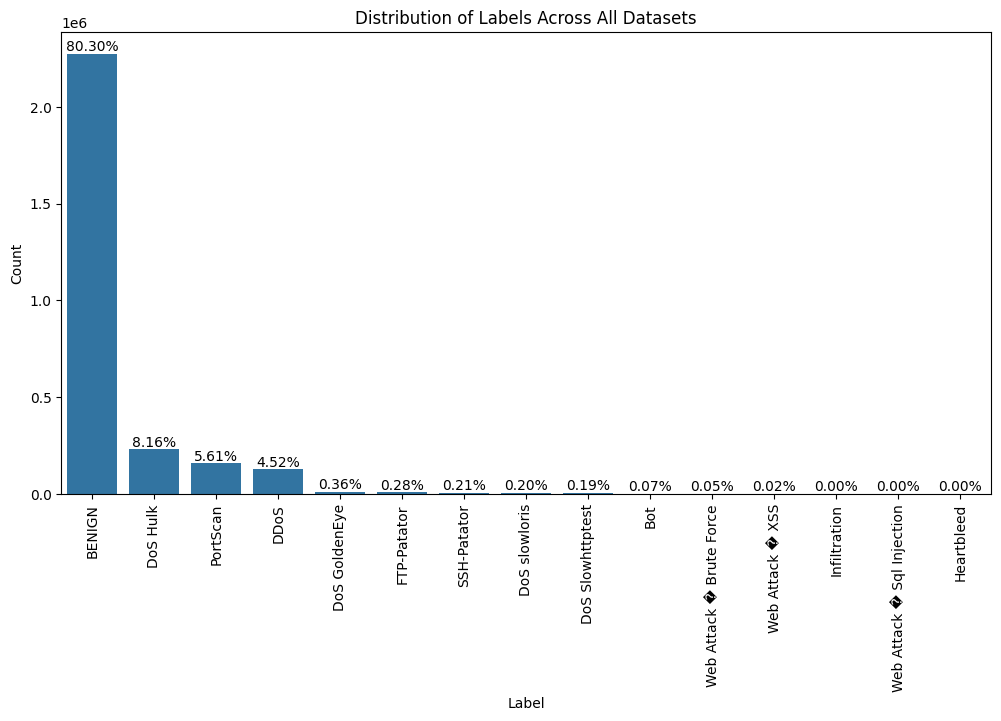

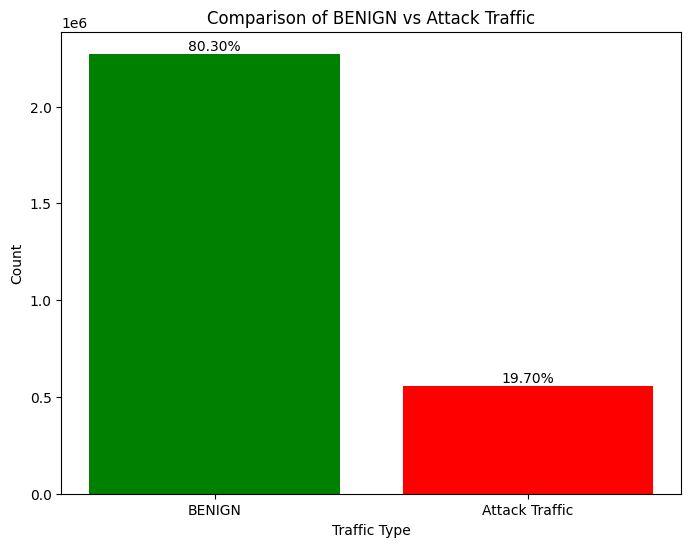

In [16]:
# Plot the distribution of labels across all datasets
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)
plt.title("Distribution of Labels Across All Datasets")
plt.xticks(rotation=90)
plt.xlabel("Label")
plt.ylabel("Count")
# Annotate percentages on the bars
for p in plt.gca().patches:
    percentage = 100 * p.get_height() / len(df)
    plt.gca().annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                       textcoords='offset points')

# Add a comparison graph for benign vs. other traffic
label_counts = df['Label'].value_counts()
benign_count = label_counts['BENIGN']
label_percentages = [100 * benign_count / len(df), 100 * (len(df) - benign_count) / len(df)]
other_count = label_counts.drop('BENIGN').sum()

plt.figure(figsize=(8, 6))
plt.bar(['BENIGN', 'Attack Traffic'], [benign_count, other_count], color=['green', 'red'])
plt.title("Comparison of BENIGN vs Attack Traffic")
plt.xlabel("Traffic Type")
plt.ylabel("Count")
# Annotate percentages on the bars
for i, bar in enumerate(plt.gca().patches):
    percentage = label_percentages[i]
    plt.gca().annotate(f'{percentage:.2f}%', 
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', 
                       xytext=(0, 5), textcoords='offset points')
plt.show()

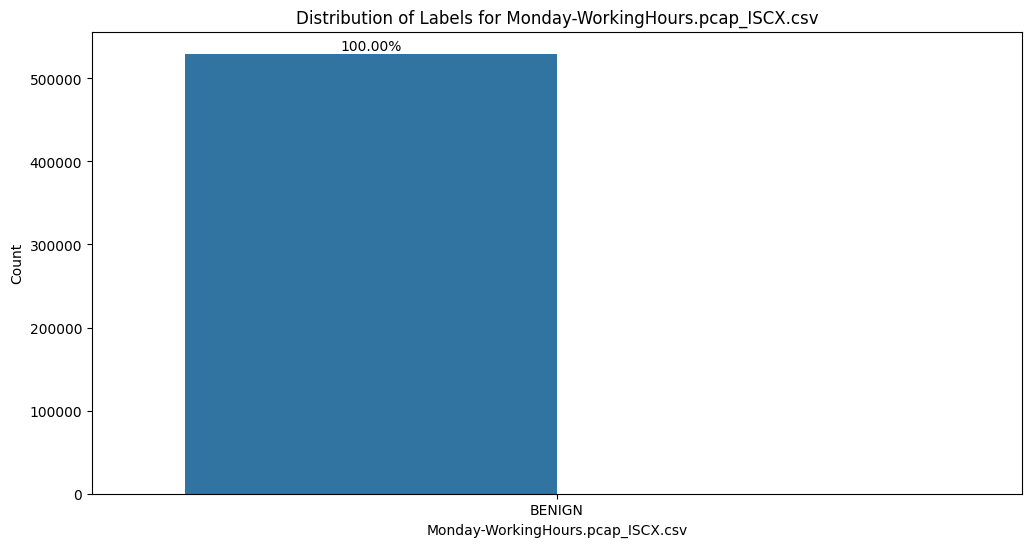

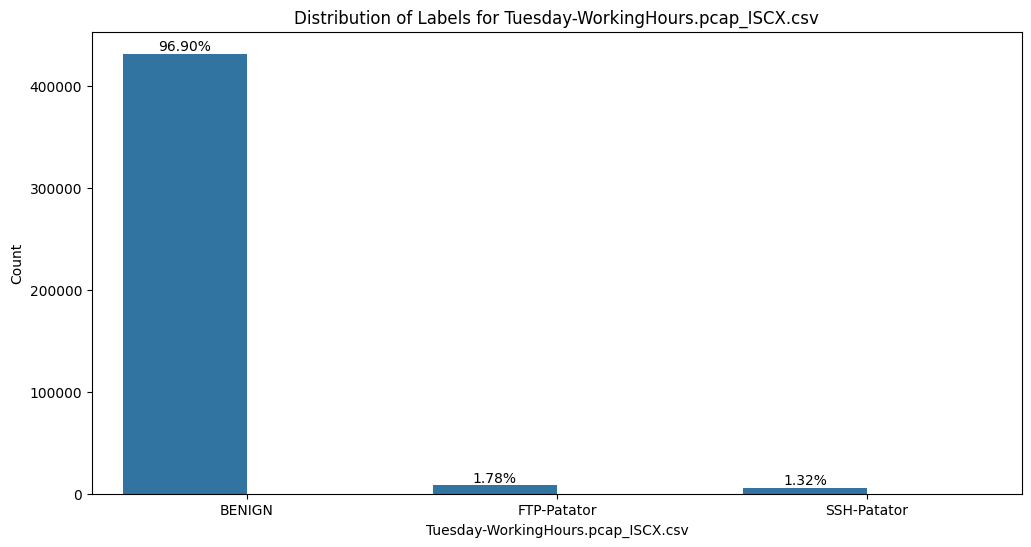

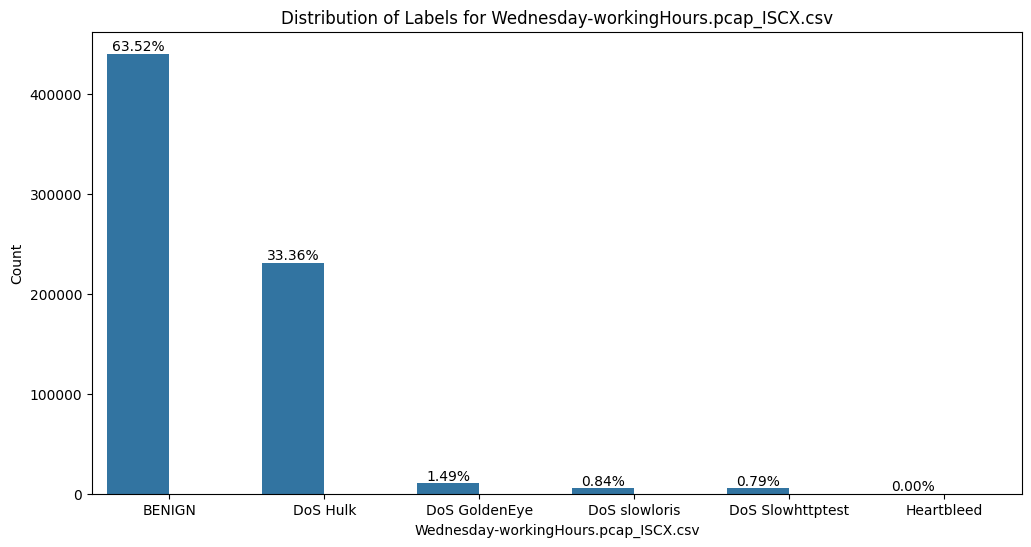

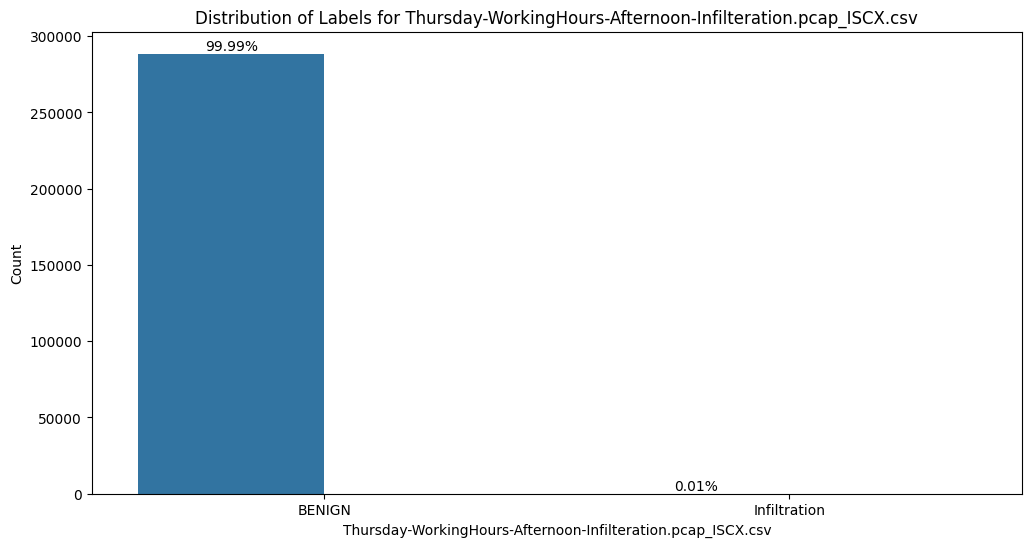

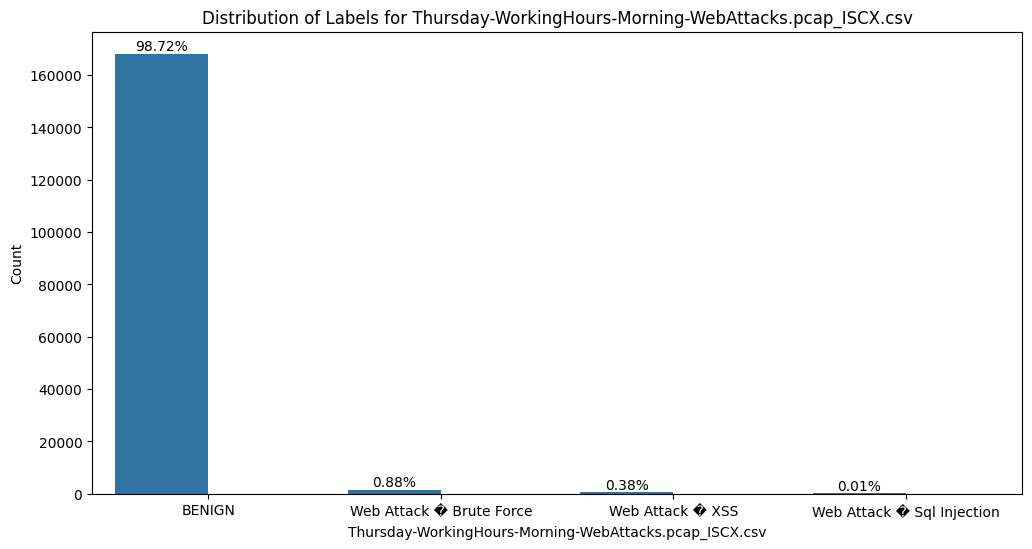

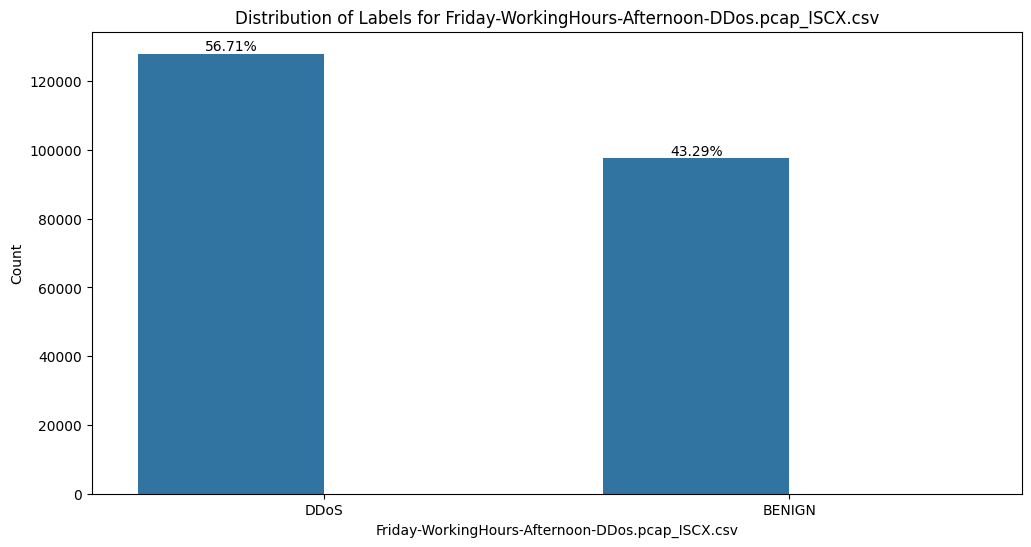

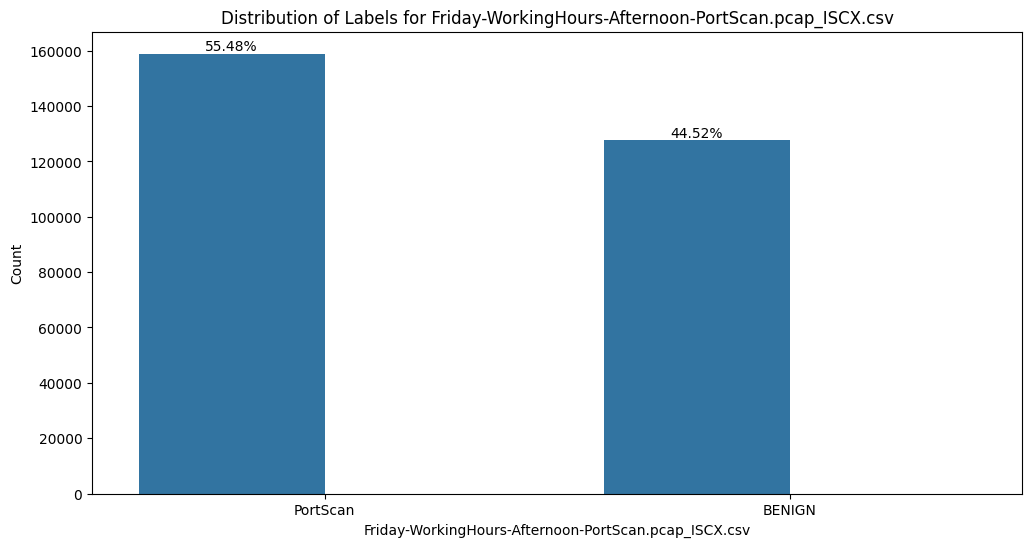

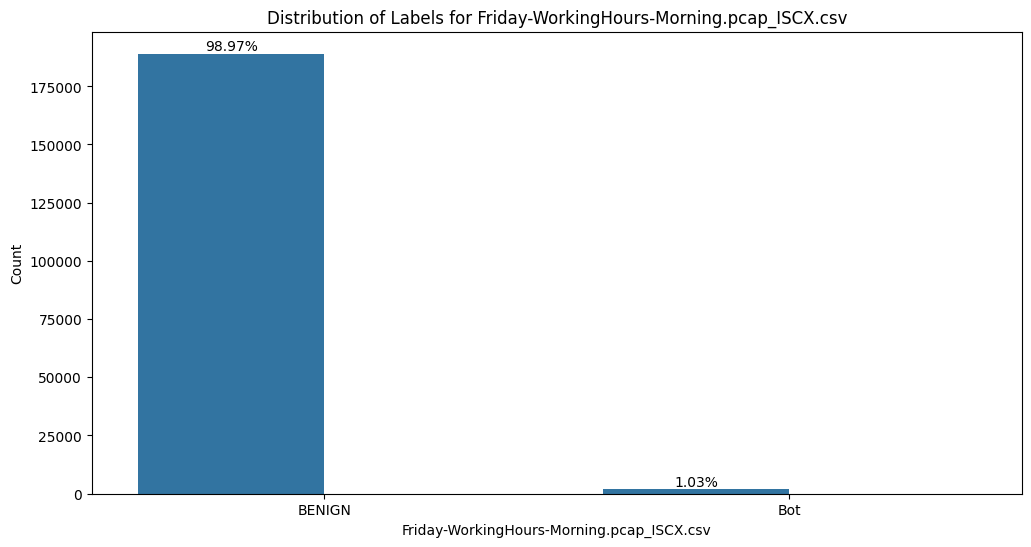

In [17]:
# Generate graphs for attack distribution in each dataset
for idx, file_path in enumerate(file_paths, start=1):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove whitespace from column names
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)
    plt.title(f"Distribution of Labels for Dataset {idx}")
    plt.xticks(rotation=90)
    plt.xlabel(file_path.split('/')[-1])  # Use the file name as the x-axis label
    for bar in plt.gca().patches:
        bar.set_width(0.4)  # Make the bars thinner
    plt.ylabel("Count")
    
    # Update the title to include the dataset name
    plt.title(f"Distribution of Labels for {file_path.split('/')[-1]}")
    # Adjust the x-axis labels to be horizontal
    plt.xticks(rotation=0)
    label_counts = df['Label'].value_counts()
    for p in plt.gca().patches:
        percentage = 100 * p.get_height() / len(df)
        plt.gca().annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                           textcoords='offset points')
    plt.show()

# 2. Data Cleaning

In [18]:
#2.1 Dealing with duplicates
print(f'Before Cremoving duplicates: {df.shape}')
duplicates = df[df.duplicated()]
print(f'Number of duplicates: {len(duplicates)}')
df.drop_duplicates(inplace = True)
print(f'After removing duplicates: {df.shape}')

Before Cremoving duplicates: (191033, 79)
Number of duplicates: 6888
After removing duplicates: (184145, 79)


In [19]:
#2.2 Handling missing values both numeric and non-numeric columns
# Identify columns with missing values
missing_val = df.isna().sum()
print("Columns with missing values:")
print(missing_val.loc[missing_val > 0])

# Handle missing values for numeric columns (fill with mean)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Handle missing values for non-numeric columns (fill with mode)
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
for col in non_numeric_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verify if there are still any missing values
print(f"Missing values after filling: {df.isna().sum().sum()}")

Columns with missing values:
Flow Bytes/s    28
dtype: int64
Missing values after filling: 0


In [20]:
#2.3 Handling infinite values

# Initial count of missing and infinite values
print(f'Initial missing values: {df.isna().sum().sum()}')
print(f'Initial infinite values: {df.isin([np.inf, -np.inf]).sum().sum()}')

# Drop rows with infinite values
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

# Verify that infinite values are removed
inf_count = df.isin([np.inf, -np.inf]).sum()
print("Columns with infinite values after processing (should be empty):")
print(inf_count[inf_count > 0])

# Final missing value check
print(f"Missing values after dropping rows: {df.isna().sum().sum()}")

Initial missing values: 0
Initial infinite values: 202
Columns with infinite values after processing (should be empty):
Series([], dtype: int64)
Missing values after dropping rows: 0


In [21]:
df.shape

(184044, 79)

**3. View Data and Show Analysis on Rows and Columns**

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184044 entries, 0 to 191032
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             184044 non-null  int64  
 1   Flow Duration                184044 non-null  int64  
 2   Total Fwd Packets            184044 non-null  int64  
 3   Total Backward Packets       184044 non-null  int64  
 4   Total Length of Fwd Packets  184044 non-null  int64  
 5   Total Length of Bwd Packets  184044 non-null  int64  
 6   Fwd Packet Length Max        184044 non-null  int64  
 7   Fwd Packet Length Min        184044 non-null  int64  
 8   Fwd Packet Length Mean       184044 non-null  float64
 9   Fwd Packet Length Std        184044 non-null  float64
 10  Bwd Packet Length Max        184044 non-null  int64  
 11  Bwd Packet Length Min        184044 non-null  int64  
 12  Bwd Packet Length Mean       184044 non-null  float64
 13  Bwd 

In [23]:
pd.options.display.max_rows = 80

print('Overview of Columns:')
df.describe().transpose()

Overview of Columns:


,count,mean,std,min,25%,50%,75%,max
Destination Port,184044.0,6.988792e+03,1.694558e+04,0.0,53.000000,80.000000,443.000000,6.494800e+04
Flow Duration,184044.0,1.207949e+07,3.118838e+07,-12.0,208.000000,32876.500000,597595.250000,1.200000e+08
Total Fwd Packets,184044.0,1.425953e+01,1.118402e+03,1.0,2.000000,2.000000,4.000000,2.079640e+05
Total Backward Packets,184044.0,1.700061e+01,1.507625e+03,0.0,1.000000,2.000000,2.000000,2.846020e+05
Total Length of Fwd Packets,184044.0,6.194786e+02,8.072434e+03,0.0,42.000000,70.000000,168.000000,1.235152e+06
Total Length of Bwd Packets,184044.0,2.946014e+04,3.376881e+06,0.0,6.000000,158.000000,356.000000,6.270000e+08
Fwd Packet Length Max,184044.0,1.803722e+02,5.640799e+02,0.0,30.000000,42.000000,69.000000,2.482000e+04
Fwd Packet Length Min,184044.0,2.386714e+01,4.204268e+01,0.0,0.000000,23.000000,42.000000,2.325000e+03
Fwd Packet Length Mean,184044.0,5.288932e+01,1.188826e+02,0.0,18.500000,39.000000,51.500000,5.940857e+03
Fwd Packet Length Std,184044.0,5.207167e+01,1.631725e+02,0.0,0.000000,0.000000,21.920310,7.049469e+03


In [24]:
df.columns.tolist()


['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'UR

In [25]:
# Calculate unique values for each column
num_unique = df.nunique()

# Identify columns to drop (with only one unique value)
one_variable = num_unique[num_unique == 1]
dropped_cols = one_variable.index

# Keep only the columns with more than one unique value in the original DataFrame
df = df[num_unique[num_unique > 1].index]

# Output the dropped columns
print('Dropped columns:')
print(dropped_cols)
df.shape

Dropped columns:
Index(['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')


(184044, 69)